# Setup

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../benchmark')
import utils as bu
sys.path.append('../piv')
from points_df import Points
import trackpy as tp
import czifile as czi
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [56]:
# Tracking individual myosin spots to measure cortex rebound after laser ablation
diameter = 9  # Expected feature size for myosin puncta (should be odd number)
minmass = 140  # Minimum integrated brightness
separation = 8  # Minimum separation between features
search_range = 8  # Maximum displacement between frames
memory = 0  # Number of frames a feature can vanish before being lost

In [38]:
# Search area
min_x_parallel = 0
max_x_parallel = 1
abs_x_perpendicular = 40 # in pixels
min_length = 2

# Tracking time window
frames_before_cut = 1  # Start tracking 1 frame before cut
frames_after_cut = 10  # Track for this many frames after cut

In [39]:
sample_cell = '220530-E3_Out'

# Track Annotated Points Using Trackpy
This notebook uses trackpy's feature detection and linking to track nuclear positions across frames, then compares the results with manual annotations.

## Track one cell

In [57]:
# --- Load experiment and image data ---
image_dir = '../data/ablation-czi/' + sample_cell + '.czi'
with czi.CziFile(image_dir) as image_czi:
    image_data = image_czi.asarray()

In [58]:
# Squeeze and normalize channels
channel_red   = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
channel_green = np.squeeze(image_data[:, :, 1, :, :, :, :, :])
channel_red_norm    = channel_red / channel_red.max()
channel_green_norm  = channel_green / channel_green.max()
num_slices = channel_red_norm.shape[0]

In [59]:
# --- Load annotated points to get cut time ---
df = Points.from_csv('../out/points.csv')
points = df.points_by_cell(sample_cell)

# Get cut time from annotated data
cut_points = points[points['cut'] == True]
if len(cut_points) == 0:
    raise ValueError(f"No cut points found for cell {sample_cell}")
cut_time = cut_points['frame'].min()

# Define tracking window relative to cut
min_frame = max(0, cut_time - frames_before_cut)
max_frame = min(num_slices - 1, cut_time + frames_after_cut)

print(f"Cut time: frame {cut_time}")
print(f"Tracking from frame {min_frame} (cut - {cut_time - min_frame}) to frame {max_frame} (cut + {max_frame - cut_time})")

Cut time: frame 4
Tracking from frame 3 (cut - 1) to frame 14 (cut + 10)


In [60]:
# Detect features in tracking window
features_list = []
for frame_idx in range(min_frame, max_frame + 1):
    frame = (channel_red_norm[frame_idx] * 255).astype(np.uint8)
    
    # Locate features
    features = tp.locate(frame, diameter=diameter, minmass=minmass, separation=separation)
    features['frame'] = frame_idx
    features_list.append(features)

# Combine all features
all_features = pd.concat(features_list, ignore_index=True)

num_frames = max_frame - min_frame + 1
print(f"Detecting features in frames {min_frame} to {max_frame} ({num_frames} frames)")
print(f"Detected {len(all_features)} features across {num_frames} frames")
print(f"Average {len(all_features)/num_frames:.1f} features per frame")

all_features.head()

Detecting features in frames 3 to 14 (12 frames)
Detected 3573 features across 12 frames
Average 297.8 features per frame


y           x        mass      size       ecc     signal  \
0  100.085532  308.046363  306.528327  2.049156  0.184118  19.724645   
1  100.864820  376.715235  221.136543  1.995563  0.121222  15.191652   
2  103.516238  264.615020  181.074687  2.233949  0.250285  10.291119   
3  103.311347  292.487546  265.608878  1.968385  0.047206  18.254485   
4  103.980442  242.431122  144.075664  2.211596  0.257226   7.473313   

   raw_mass        ep  frame  
0    9128.0  0.009226      3  
1    8988.0  0.010535      3  
2    8947.0  0.010991      3  
3    8974.0  0.010686      3  
4    8692.0  0.015049      3

In [61]:
# Link features across frames
trajectories = tp.link(all_features, search_range=search_range, memory=memory)

print(f"Found {trajectories['particle'].nunique()} unique trajectories")
print(f"Trajectory lengths:")
print(trajectories.groupby('particle').size().describe())

trajectories.head()

Frame 14: 295 trajectories present.
Found 1101 unique trajectories
Trajectory lengths:
count    1101.000000
mean        3.245232
std         3.366653
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        12.000000
dtype: float64


y           x        mass      size       ecc     signal  \
0  100.085532  308.046363  306.528327  2.049156  0.184118  19.724645   
1  100.864820  376.715235  221.136543  1.995563  0.121222  15.191652   
2  103.516238  264.615020  181.074687  2.233949  0.250285  10.291119   
3  103.311347  292.487546  265.608878  1.968385  0.047206  18.254485   
4  103.980442  242.431122  144.075664  2.211596  0.257226   7.473313   

   raw_mass        ep  frame  particle  
0    9128.0  0.009226      3         0  
1    8988.0  0.010535      3         1  
2    8947.0  0.010991      3         2  
3    8974.0  0.010686      3         3  
4    8692.0  0.015049      3         4

In [62]:
# Calculate cut coordinates for all trajectories
# Get cut points to calculate cut coordinate system
cut_points = points[points['cut'] == True]

if len(cut_points) != 2:
    print(f"Error: need exactly 2 cut points, found {len(cut_points)}")
else:
    # Sort cut points so cut1 is the one with lowest y value
    cut_points_sorted = cut_points.sort_values("y", ascending=False)
    cut1 = cut_points_sorted.iloc[0]
    cut2 = cut_points_sorted.iloc[1]
    
    cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
    cut_length = np.linalg.norm(cut_vector)
    
    if cut_length == 0:
        print("Error: cut points are identical")
    else:
        cut_unit = cut_vector / cut_length
        perp_unit = np.array([-cut_unit[1], cut_unit[0]])
        origin = np.array([cut1["x"], cut1["y"]])
        
        # Calculate cut coordinates for all trajectories
        trajectories['x_parallel'] = np.nan
        trajectories['x_perpendicular'] = np.nan
        
        for traj_idx in trajectories.index:
            point = np.array([trajectories.loc[traj_idx, 'x'], trajectories.loc[traj_idx, 'y']])
            relative_pos = point - origin
            trajectories.loc[traj_idx, 'x_parallel'] = np.dot(relative_pos, cut_unit) / cut_length
            trajectories.loc[traj_idx, 'x_perpendicular'] = np.dot(relative_pos, perp_unit)
        
        print(f"Calculated cut coordinates for {len(trajectories)} trajectory points")
        print(f"Cut length: {cut_length:.2f} pixels")

trajectories.head()

Calculated cut coordinates for 3573 trajectory points
Cut length: 111.22 pixels


y           x        mass      size       ecc     signal  \
0  100.085532  308.046363  306.528327  2.049156  0.184118  19.724645   
1  100.864820  376.715235  221.136543  1.995563  0.121222  15.191652   
2  103.516238  264.615020  181.074687  2.233949  0.250285  10.291119   
3  103.311347  292.487546  265.608878  1.968385  0.047206  18.254485   
4  103.980442  242.431122  144.075664  2.211596  0.257226   7.473313   

   raw_mass        ep  frame  particle  x_parallel  x_perpendicular  
0    9128.0  0.009226      3         0    0.258007      -152.410583  
1    8988.0  0.010535      3         1    0.873754      -147.310955  
2    8947.0  0.010991      3         2   -0.133658      -151.720161  
3    8974.0  0.010686      3         3    0.116567      -150.170404  
4    8692.0  0.015049      3         4   -0.332984      -152.653088

In [63]:
# Filter particles based on their FIRST FRAME position only
# Then keep tracking them even if they move beyond the initial region

# Get first frame for each particle
first_frame_positions = trajectories.groupby('particle').first().reset_index()

# Filter based on first frame position
particles_in_region = first_frame_positions[
    (first_frame_positions['x_parallel'] >= min_x_parallel) & 
    (first_frame_positions['x_parallel'] <= max_x_parallel) & 
    (first_frame_positions['x_perpendicular'].abs() <= abs_x_perpendicular)
]['particle'].values

print(f"Found {len(particles_in_region)} particles starting in cut region")
print(f"  Initial x_parallel: [{min_x_parallel}, {max_x_parallel}]")
print(f"  Initial abs(x_perpendicular): [0, {abs_x_perpendicular}]")
print(f"  Note: Particles will be tracked even if they move beyond this region")


# Get all trajectories for these particles (not just points in region)
filtered_trajectories = trajectories[trajectories['particle'].isin(particles_in_region)].copy()

print(f"Trajectories per frame:", filtered_trajectories.groupby('frame').size())
print(f"\nTotal trajectory points (all frames): {len(filtered_trajectories)}")

Found 69 particles starting in cut region
  Initial x_parallel: [0, 1]
  Initial abs(x_perpendicular): [0, 40]
  Note: Particles will be tracked even if they move beyond this region
Trajectories per frame: frame
3     36
4     12
5     16
6     14
7     12
8     12
9     13
10    13
11    12
12    12
13    12
14    12
dtype: int64

Total trajectory points (all frames): 176


In [64]:
# Create tracked dataframe with all particles in cut region
# Only keep particles that appear in at least 2 frames
tracked_points_list = []
point_id_counter = 0

for particle_id in particles_in_region:
    particle_traj = trajectories[trajectories['particle'] == particle_id].copy()
    
    # Only keep if particle appears in at least 2 frames
    if len(particle_traj) >= min_length:
        particle_traj['point_id'] = point_id_counter
        point_id_counter += 1
        tracked_points_list.append(particle_traj[['point_id', 'frame', 'x', 'y', 'x_perpendicular']])

tracked_df = pd.concat(tracked_points_list, ignore_index=True)
tracked_df = tracked_df.sort_values(['point_id', 'frame']).reset_index(drop=True)

print(f"Tracked {tracked_df['point_id'].nunique()} particles across {tracked_df['frame'].nunique()} frames")
print(f"(Only particles appearing in at least 2 frames)")
tracked_df.head()

Tracked 24 particles across 12 frames
(Only particles appearing in at least 2 frames)


point_id  frame           x           y  x_perpendicular
0         0      3  390.854321  208.772840       -38.726984
1         0      4  390.772397  207.072034       -40.429574
2         1      3  294.852566  217.052674       -36.505726
3         1      4  299.943005  215.631384       -37.603816
4         2      3  373.761855  221.472121       -27.128646

In [65]:
# Debug: Check what frames we have
print(f"tracked_df frames: {sorted(tracked_df['frame'].unique())}")
print(f"tracked_df shape: {tracked_df.shape}")
print(f"Points per frame:")
print(tracked_df.groupby('frame').size())

tracked_df frames: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]
tracked_df shape: (131, 5)
Points per frame:
frame
3     11
4     12
5     12
6     13
7      9
8     10
9     11
10    11
11    10
12    10
13    12
14    10
dtype: int64


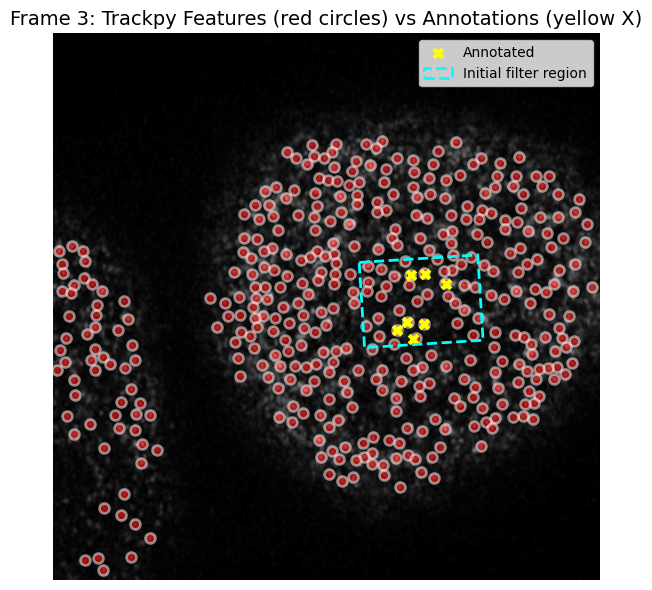

Detected 404 features


In [66]:
# Visualize a single frame with detected features
frame_idx = 3
frame = (channel_red_norm[frame_idx] * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, cmap='gray')

# Show detected features
frame_features = all_features[all_features['frame'] == frame_idx]
ax.scatter(frame_features['x'], frame_features['y'], c='red', s=50, alpha=0.5, edgecolors='white', linewidths=2)

# Show annotated points
ann_points = points[points['frame'] == frame_idx]
ax.scatter(ann_points['x'], ann_points['y'], c='yellow', s=40, marker='x', linewidths=3, label='Annotated')

# Visualize the filtering region (initial position constraint)
# Calculate the boundary lines for the filtering square
# x_parallel: [min_x_parallel, max_x_parallel], x_perpendicular: [-abs_x_perpendicular, +abs_x_perpendicular]
# Convert cut coordinates back to image coordinates
corners = []
for x_par in [min_x_parallel, max_x_parallel]:
    for x_perp in [-abs_x_perpendicular, abs_x_perpendicular]:
        point_cut = origin + x_par * cut_length * cut_unit + x_perp * perp_unit
        corners.append(point_cut)

# Draw the filtering region as a rectangle
from matplotlib.patches import Polygon
rect_points = np.array([
    origin + min_x_parallel * cut_length * cut_unit - abs_x_perpendicular * perp_unit,
    origin + max_x_parallel * cut_length * cut_unit - abs_x_perpendicular * perp_unit,
    origin + max_x_parallel * cut_length * cut_unit + abs_x_perpendicular * perp_unit,
    origin + min_x_parallel * cut_length * cut_unit + abs_x_perpendicular * perp_unit,
])
polygon = Polygon(rect_points, fill=False, edgecolor='cyan', linewidth=2, linestyle='--', label='Initial filter region')
ax.add_patch(polygon)

ax.set_title(f'Frame {frame_idx}: Trackpy Features (red circles) vs Annotations (yellow X)', fontsize=14)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Detected {len(frame_features)} features")

In [67]:
# Animate all tracked points in cut region with individual colors
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.cm as cm

tracked_df_sorted = tracked_df.sort_values(['frame', 'point_id'])

# Use all tracked frames
frames = sorted(tracked_df_sorted['frame'].unique())

# Create color map for each unique point_id
unique_points = sorted(tracked_df_sorted['point_id'].unique())
colors = cm.tab20(np.linspace(0, 1, len(unique_points)))
point_colors = dict(zip(unique_points, colors))

print(f"Animating {len(frames)} frames (frames {frames[0]} to {frames[-1]})")
print(f"Tracking {len(unique_points)} unique particles with individual colors")

fig = plt.figure(figsize=(8, 8))
def animate(i):
    plt.clf()
    frame = frames[i]
    
    # Background image
    bg_img = (channel_red_norm[frame] * 255).astype(np.uint8)
    plt.imshow(bg_img, cmap='gray', alpha=0.7)
    
    # Visualize the filtering region (initial position constraint)
    from matplotlib.patches import Polygon
    rect_points = np.array([
        origin + min_x_parallel * cut_length * cut_unit - abs_x_perpendicular * perp_unit,
        origin + max_x_parallel * cut_length * cut_unit - abs_x_perpendicular * perp_unit,
        origin + max_x_parallel * cut_length * cut_unit + abs_x_perpendicular * perp_unit,
        origin + min_x_parallel * cut_length * cut_unit + abs_x_perpendicular * perp_unit,
    ])
    polygon = Polygon(rect_points, fill=False, edgecolor='cyan', linewidth=2, linestyle='--', alpha=0.7)
    plt.gca().add_patch(polygon)
    
    # Trackpy tracked points in cut region - each with its own color
    trk_pts = tracked_df_sorted[tracked_df_sorted['frame'] == frame]
    for point_id in trk_pts['point_id'].unique():
        pt = trk_pts[trk_pts['point_id'] == point_id]
        plt.scatter(pt['x'], pt['y'], facecolors='none', edgecolors=[point_colors[point_id]], 
                   s=diameter**2, linewidths=2, alpha=0.9)
        # Add point id text
        for _, row in pt.iterrows():
            plt.text(row['x'], row['y'], str(point_id), color=point_colors[point_id], fontsize=10, ha='center', va='center')
    
    # Show cut points for reference
    cut_pts = points[points['cut'] == True]
    plt.scatter(cut_pts['x'], cut_pts['y'], c='red', label='Cut', s=100, marker='x', linewidths=3)
    
    # Add legend entry for filter region
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', marker='x', linestyle='None', markersize=10, label='Cut', markeredgewidth=3),
        Line2D([0], [0], color='cyan', linestyle='--', linewidth=2, label='Initial filter region')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.title(f'Frame {frame} | Tracked: {len(trk_pts)} particles in cut region', fontsize=16)
    plt.xlim(0, bg_img.shape[1])
    plt.ylim(bg_img.shape[0], 0)
    plt.axis('off')

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=300, repeat=False)

html = HTML(ani.to_jshtml())
plt.close(fig)

html

Animating 12 frames (frames 3 to 14)
Tracking 24 unique particles with individual colors


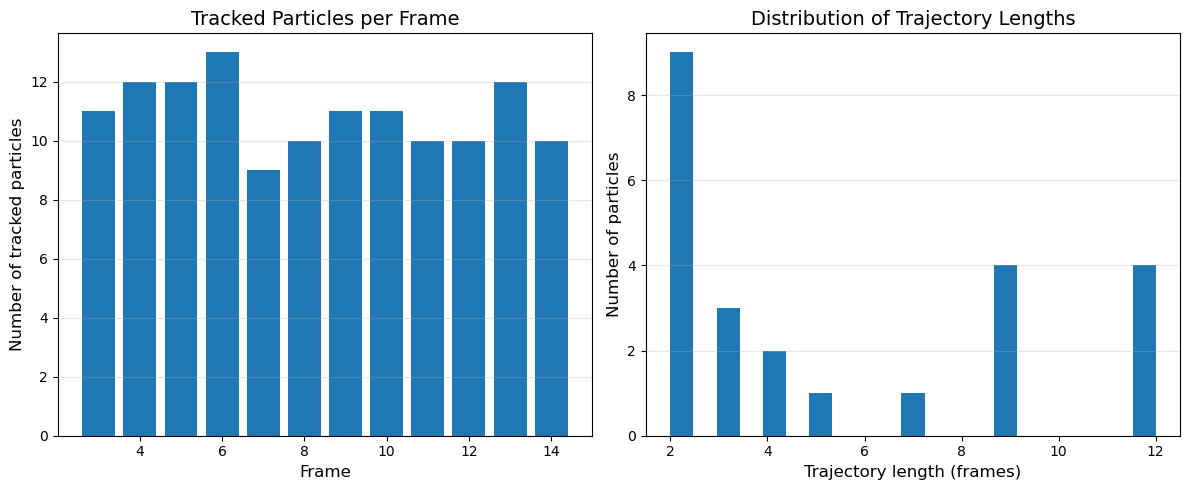

Total tracked particles: 24
Total tracking points: 131
Average trajectory length: 5.5 frames
Median trajectory length: 4 frames


In [68]:
# Show distribution of tracked points
plt.figure(figsize=(12, 5))

# Plot 1: Points per frame
plt.subplot(1, 2, 1)
points_per_frame = tracked_df.groupby('frame').size()
plt.bar(points_per_frame.index, points_per_frame.values)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Number of tracked particles', fontsize=12)
plt.title('Tracked Particles per Frame', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Trajectory lengths
plt.subplot(1, 2, 2)
traj_lengths = tracked_df.groupby('point_id').size()
plt.hist(traj_lengths, bins=21)
plt.xlabel('Trajectory length (frames)', fontsize=12)
plt.ylabel('Number of particles', fontsize=12)
plt.title('Distribution of Trajectory Lengths', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total tracked particles: {tracked_df['point_id'].nunique()}")
print(f"Total tracking points: {len(tracked_df)}")
print(f"Average trajectory length: {traj_lengths.mean():.1f} frames")
print(f"Median trajectory length: {traj_lengths.median():.0f} frames")

In [69]:
# Calculate frame_rel and velocities for plotting
df = tracked_df.copy()
df['cell_id'] = sample_cell  # Add cell_id for compatibility

# Calculate frame_rel relative to cut
df['frame_rel'] = df['frame'] - cut_time

# Sort by point_id and frame
df = df.sort_values(['point_id', 'frame']).reset_index(drop=True)

# Calculate velocities
df["dx_perpendicular"] = df.groupby("point_id")["x"].shift(-1) - df["x"]
df["dy_perpendicular"] = df.groupby("point_id")["y"].shift(-1) - df["y"]
df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]

# Calculate v_perpendicular using the cut coordinate system
# First need to recalculate perpendicular components for velocity
for idx in df.index:
    next_idx = idx + 1
    if next_idx < len(df) and df.loc[idx, 'point_id'] == df.loc[next_idx, 'point_id']:
        dx = df.loc[next_idx, 'x'] - df.loc[idx, 'x']
        dy = df.loc[next_idx, 'y'] - df.loc[idx, 'y']
        dt = df.loc[next_idx, 'frame'] - df.loc[idx, 'frame']
        
        if dt > 0:
            # Project velocity onto perpendicular direction
            v_perpendicular = (dx * perp_unit[0] + dy * perp_unit[1]) / dt
            df.loc[idx, 'v_perpendicular'] = v_perpendicular
        else:
            df.loc[idx, 'v_perpendicular'] = np.nan
    else:
        df.loc[idx, 'v_perpendicular'] = np.nan

tracked_df_with_velocities = df.copy()

print(f"Calculated velocities for {len(tracked_df_with_velocities)} points")
tracked_df_with_velocities.head(20)

Calculated velocities for 131 points


point_id  frame           x           y  x_perpendicular        cell_id  \
0          0      3  390.854321  208.772840       -38.726984  220530-E3_Out   
1          0      4  390.772397  207.072034       -40.429574  220530-E3_Out   
2          1      3  294.852566  217.052674       -36.505726  220530-E3_Out   
3          1      4  299.943005  215.631384       -37.603816  220530-E3_Out   
4          2      3  373.761855  221.472121       -27.128646  220530-E3_Out   
5          2      4  374.123837  219.524419       -29.049704  220530-E3_Out   
6          3      3  334.247853  226.101889       -24.994990  220530-E3_Out   
7          3      4  336.282377  223.648865       -27.315102  220530-E3_Out   
8          3      5  336.909289  222.224964       -28.696724  220530-E3_Out   
9          3      6  337.876180  220.891396       -29.966794  220530-E3_Out   
10         3      7  337.970337  220.160000       -30.690813  220530-E3_Out   
11         3      8  337.915392  219.852385       -31.001276  220530-E3_Out   
12         3      9  337.278675  218.999150       -31.892893  220530-E3_Out   
13         3     10  337.180376  218.260125       -32.636640  220530-E3_Out   
14         3     11  337.517313  218.594832       -32.281391  220530-E3_Out   
15         3     12  337.000963  218.812229       -32.096922  220530-E3_Out   
16         3     13  336.955452  218.229056       -32.681804  220530-E3_Out   
17         3     14  336.695192  218.507335       -32.420457  220530-E3_Out   
18         4      3  398.111753  266.473814        19.316364  220530-E3_Out   
19         4      4  398.415916  268.768168        21.625312  220530-E3_Out   

    frame_rel  dx_perpendicular  dy_perpendicular   dt  v_perpendicular  
0          -1         -0.081924         -1.700806  1.0        -1.702590  
1           0               NaN               NaN  NaN              NaN  
2          -1          5.090439         -1.421290  1.0        -1.098090  
3           0               NaN               NaN  NaN              NaN  
4          -1          0.361982         -1.947702  1.0        -1.921058  
5           0               NaN               NaN  NaN              NaN  
6          -1          2.034523         -2.453024  1.0        -2.320112  
7           0          0.626912         -1.423901  1.0        -1.381622  
8           1          0.966892         -1.333568  1.0        -1.270070  
9           2          0.094157         -0.731396  1.0        -0.724020  
10          3         -0.054946         -0.307615  1.0        -0.310463  
11          4         -0.636717         -0.853235  1.0        -0.891617  
12          5         -0.098299         -0.739025  1.0        -0.743747  
13          6          0.336937          0.334707  1.0         0.355249  
14          7         -0.516350          0.217397  1.0         0.184468  
15          8         -0.045511         -0.583173  1.0        -0.584882  
16          9         -0.260261          0.278279  1.0         0.261347  
17         10               NaN               NaN  NaN              NaN  
18         -1          0.304163          2.294354  1.0         2.308948  
19          0          0.518363          0.125294  1.0         0.157671

In [70]:
df = tracked_df_with_velocities.copy()

def weighted_mean_v_perpendicular_per_cell(cell_group):
    """Calculate weighted mean perpendicular velocity for all points in a cell"""
    pos_mask = cell_group['x_perpendicular'] > 0
    neg_mask = cell_group['x_perpendicular'] < 0
    
    pos_count = pos_mask.sum()
    neg_count = neg_mask.sum()
    
    if pos_count == 0 or neg_count == 0:
        return 0
    
    # Calculate mean for each side across all timepoints
    pos_mean = cell_group.loc[pos_mask, 'v_perpendicular'].mean()
    neg_mean = cell_group.loc[neg_mask, 'v_perpendicular'].mean()
    
    # Weight by the smaller count to balance the contribution
    min_count = min(pos_count, neg_count)
    
    # Normalized weighted average
    weighted_mean = (pos_mean * min_count + neg_mean * min_count) / (2 * min_count)
    
    return weighted_mean

# Calculate weighted average v_perpendicular per cell (averaged over all timepoints)
mean_v_perp_per_cell = df.groupby('cell_id').apply(
    weighted_mean_v_perpendicular_per_cell,
    include_groups=False
).reset_index(name='mean_v_perpendicular')

# Merge back to dataframe
df = df.merge(mean_v_perp_per_cell, on='cell_id')

# Subtract average from each point's perpendicular velocity
df['v_perpendicular'] = df['v_perpendicular'] - df['mean_v_perpendicular']

df['v_perpendicular'] = np.where(
    df['x_perpendicular'] >= 0,
    df['v_perpendicular'],
    -df['v_perpendicular']
)

points_final_corrected = df.copy()
points_final_corrected.head()

point_id  frame           x           y  x_perpendicular        cell_id  \
0         0      3  390.854321  208.772840       -38.726984  220530-E3_Out   
1         0      4  390.772397  207.072034       -40.429574  220530-E3_Out   
2         1      3  294.852566  217.052674       -36.505726  220530-E3_Out   
3         1      4  299.943005  215.631384       -37.603816  220530-E3_Out   
4         2      3  373.761855  221.472121       -27.128646  220530-E3_Out   

   frame_rel  dx_perpendicular  dy_perpendicular   dt  v_perpendicular  \
0         -1         -0.081924         -1.700806  1.0         1.933187   
1          0               NaN               NaN  NaN              NaN   
2         -1          5.090439         -1.421290  1.0         1.328688   
3          0               NaN               NaN  NaN              NaN   
4         -1          0.361982         -1.947702  1.0         2.151656   

   mean_v_perpendicular  
0              0.230597  
1              0.230597  
2              0.230597  
3              0.230597  
4              0.230597

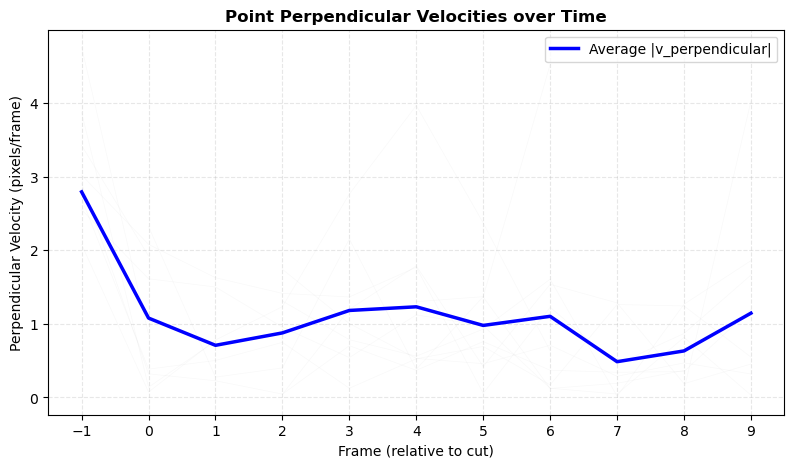

In [71]:
bu.plot_v_perpendicular_vs_time(points_final_corrected)

## Track all cells

In [72]:
# Loop over all cells and run trackpy tracking - track all points near cut area
all_points = Points.from_csv('../out/points.csv')
cellids = all_points['cell_id'].unique()

results = []
global_point_id = 0  # Counter for unique point IDs across all cells

for idx, cellid in enumerate(cellids):
    try:
        # Load cell-specific data
        cell_points = all_points.points_by_cell(cellid)
        if cell_points.empty:
            print(f"Skipping {cellid}: no points")
            continue
        
        # Get cut points to calculate cut coordinates
        cut_points = cell_points[cell_points['cut'] == True]
        if len(cut_points) != 2:
            print(f"Skipping {cellid}: needs exactly 2 cut points, found {len(cut_points)}")
            continue
        
        # Sort cut points so cut1 is the one with lowest y value
        cut_points_sorted = cut_points.sort_values("y", ascending=False)
        cut1 = cut_points_sorted.iloc[0]
        cut2 = cut_points_sorted.iloc[1]
        
        cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
        cut_length = np.linalg.norm(cut_vector)
        
        if cut_length == 0:
            print(f"Skipping {cellid}: cut points are identical")
            continue
        
        cut_unit = cut_vector / cut_length
        perp_unit = np.array([-cut_unit[1], cut_unit[0]])
        origin = np.array([cut1["x"], cut1["y"]])
        
        # Load images
        image_dir = f'../data/ablation-czi/{cellid}.czi'
        with czi.CziFile(image_dir) as image_czi:
            image_data = image_czi.asarray()
        
        channel_red = np.squeeze(image_data[:, :, 0, :, :, :, :, :])
        channel_red_norm = channel_red / channel_red.max()
        num_slices, height, width = channel_red_norm.shape
        
        # Get cut time and define tracking window
        cut_time = int(cut_points['frame'].min())
        min_frame = max(0, cut_time - frames_before_cut)
        max_frame = min(num_slices - 1, cut_time + frames_after_cut)
        
        # Detect features in tracking window
        features_list = []
        for frame_idx in range(min_frame, max_frame + 1):
            frame = (channel_red_norm[frame_idx] * 255).astype(np.uint8)
            features = tp.locate(frame, diameter=diameter, minmass=minmass, separation=separation)
            features['frame'] = frame_idx
            features_list.append(features)
        
        all_features = pd.concat(features_list, ignore_index=True)
        
        # Link features
        trajectories = tp.link(all_features, search_range=search_range, memory=memory)
        
        # Calculate cut coordinates for all trajectories
        trajectories['x_parallel'] = np.nan
        trajectories['x_perpendicular'] = np.nan
        
        for traj_idx in trajectories.index:
            point = np.array([trajectories.loc[traj_idx, 'x'], trajectories.loc[traj_idx, 'y']])
            relative_pos = point - origin
            trajectories.loc[traj_idx, 'x_parallel'] = np.dot(relative_pos, cut_unit) / cut_length
            trajectories.loc[traj_idx, 'x_perpendicular'] = np.dot(relative_pos, perp_unit)
        
        # Filter particles based on their FIRST FRAME position only
        # Then keep tracking them even if they move beyond the initial region
        
        # Get first frame for each particle
        first_frame_positions = trajectories.groupby('particle').first().reset_index()
        
        # Filter based on first frame position
        particles_in_region = first_frame_positions[
            (first_frame_positions['x_parallel'] >= min_x_parallel) & 
            (first_frame_positions['x_parallel'] <= max_x_parallel) & 
            (first_frame_positions['x_perpendicular'].abs() <= abs_x_perpendicular)
        ]['particle'].values
        
        # Create tracked dataframe with all particles in cut region
        # Only keep particles that appear in at least 2 frames
        tracked_points_list = []
        for particle_id in particles_in_region:
            particle_traj = trajectories[trajectories['particle'] == particle_id].copy()
            
            # Only keep if particle appears in at least 2 frames
            if len(particle_traj) >= min_length:
                particle_traj['point_id'] = global_point_id
                global_point_id += 1
                tracked_points_list.append(particle_traj[['point_id', 'frame', 'x', 'y']])
        
        if tracked_points_list:
            tracked_df = pd.concat(tracked_points_list, ignore_index=True)
            tracked_df['cell_id'] = cellid
            tracked_df['cut'] = False  # None of these are cut points
            tracked_df = tracked_df[['cell_id', 'point_id', 'frame', 'x', 'y', 'cut']]
            
            results.append(tracked_df)
            
            num_frames = max_frame - min_frame + 1
            num_particles = len(particles_in_region)
            print(f'Progress {idx+1}/{len(cellids)} | Cell {cellid} | Frames {min_frame}-{max_frame} ({num_frames}) | Tracked {num_particles} particles in cut region')
        else:
            print(f'Progress {idx+1}/{len(cellids)} | Cell {cellid} | No particles found in cut region')
        
        clear_output(wait=True)
        
    except Exception as e:
        print(f"Error processing {cellid}: {str(e)}")
        continue

results_df = pd.concat(results, ignore_index=True)
print(f"\nCompleted! Tracked {results_df['point_id'].nunique()} unique particles across {results_df['cell_id'].nunique()} cells")

print(f"Total tracking points: {len(results_df)}")
results_df.head()


Completed! Tracked 1918 unique particles across 156 cells
Total tracking points: 8275


cell_id  point_id  frame           x           y    cut
0  220530-E1_Out         0      3  318.884961  189.676207  False
1  220530-E1_Out         0      4  319.778198  184.279334  False
2  220530-E1_Out         1      3  367.318741  190.392157  False
3  220530-E1_Out         1      4  370.865175  191.984281  False
4  220530-E1_Out         1      5  371.927497  192.508892  False

In [73]:
results_df.to_csv('../out/trackpy_points_all.csv', index=False)
print("Saved to ../out/trackpy_points_all.csv")

Saved to ../out/trackpy_points_all.csv
